In [142]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

In [68]:
# Import train data
ne_train = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/ne_train.csv")
s_train = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/s_train.csv")

# Import test data
ne_test = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/ne_test.csv")
s_test = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/s_test.csv")

# Plots
- Plotting time series graphs of NE and S to visualize the behavior and patterns of the data --> build a reliable model
- Analysis of the New England plot
    - Multiple clear peaks around April-May
    - Looks like a gaussian distribution
    - Not mean-reverting (includes a non-zero mean)
    - Has a time trend --> may be non-stationary/trend stationary
    - No seasonality
    - No structural breaks
- Analysis of the South plot
    - Plateau at first and then increase
    - Consistent increase in the number of cases over time
    - No drops in the overall trend
    - Not mean-reverting
    - Has a time trend --> may be non-stationary/trend stationary
    - No seasonality
    - No structural breaks

<Axes: title={'center': 'Time series graph of COVID-19 confirmed cases in New England'}, xlabel='date', ylabel='Number of confirmed cases'>

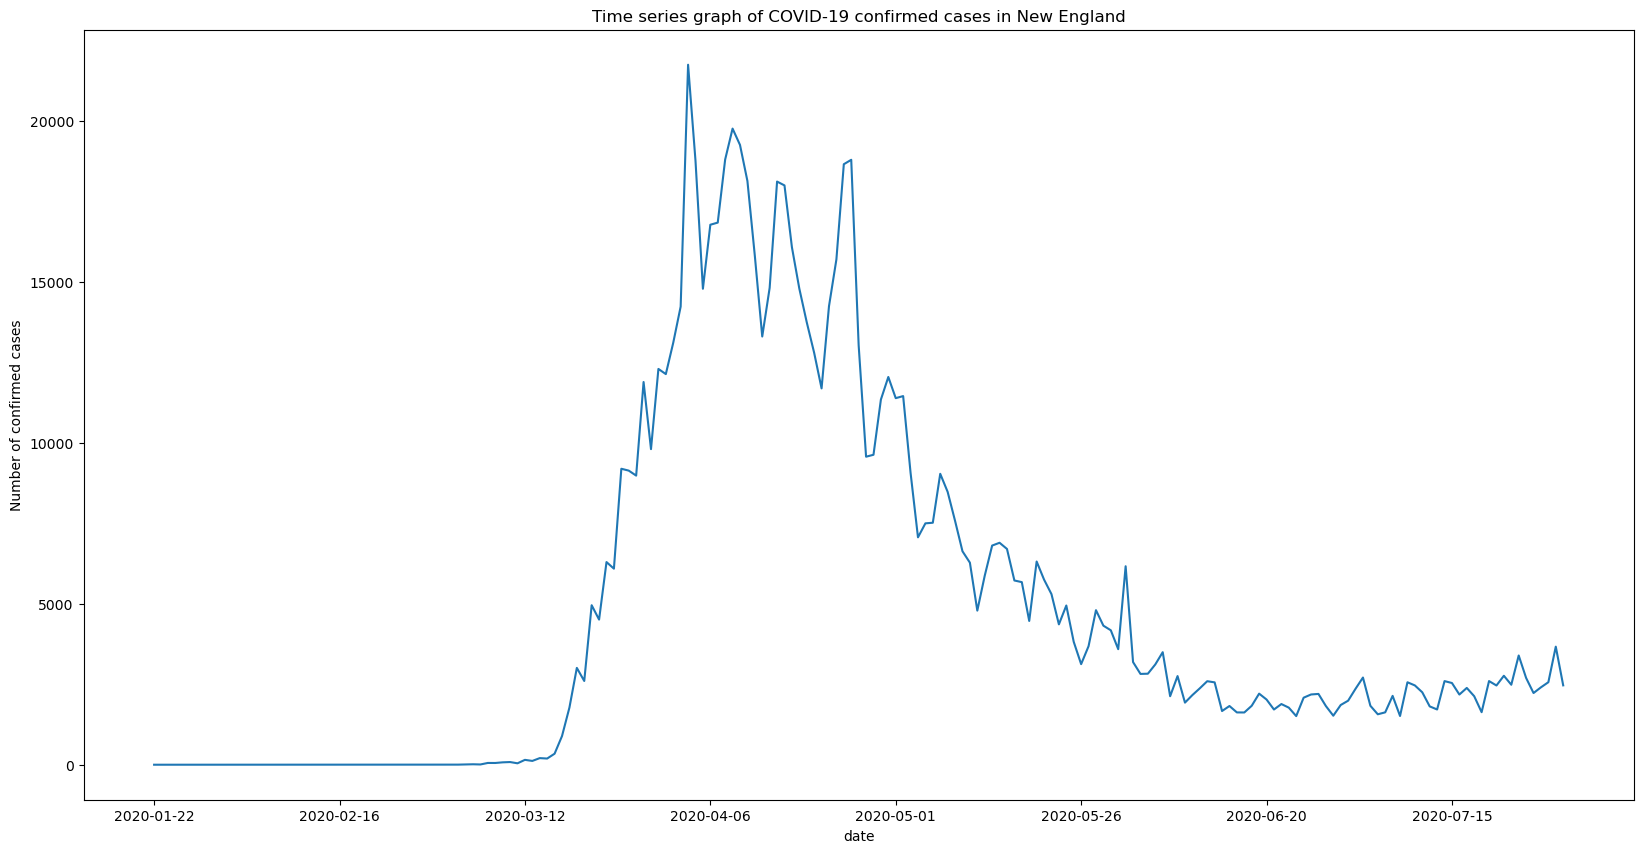

In [69]:
ne_train.plot(x = "date", y = "covid_19_confirmed_cases", figsize = (20,10),
             title = "Time series graph of COVID-19 confirmed cases in New England",
             ylabel = "Number of confirmed cases",
             legend = False)

<Axes: title={'center': 'Time series graph of COVID-19 confirmed cases in the South'}, xlabel='date', ylabel='Number of confirmed cases'>

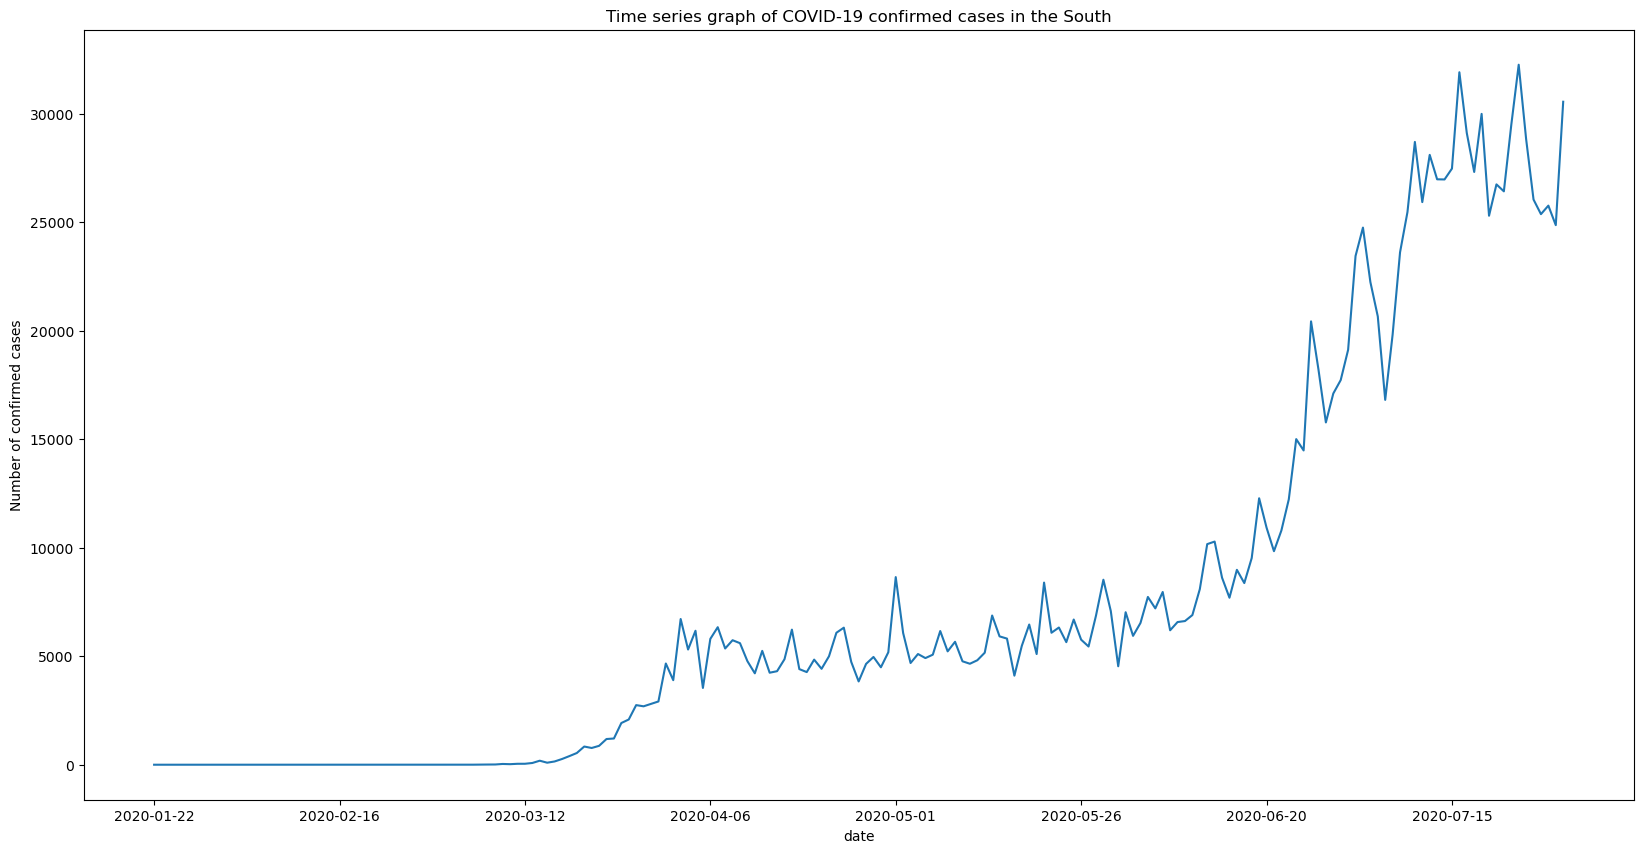

In [70]:
s_train.plot(x = "date", y = "covid_19_confirmed_cases", figsize = (20,10),
             title = "Time series graph of COVID-19 confirmed cases in the South",
             ylabel = "Number of confirmed cases",
             legend = False)

# Stationarity Tests
- A Stationary series is one whose statistical properties such as mean, variance, covariance, and standard deviation do not vary with time
    - Augmented Dickey-Fuller test (ADF Test)
    - Kwiatkowski-Phillips-Schmidt-Shin test (KPSS test)
- Determine the number of differences required to make the series stationary because a model cannot forecast on non-stationary time series data
- NE: ADF (non-stationary) but KPSS (trend stationary) --> Trend stationary
- S: Both tests (non-stationary) --> Non-stationary
- For both data sets --> remove non-stationarity --> make series strictly stationary

### ADF Test
- Unit root test
    - H0: Series is non-stationary, or series has a unit root
    - HA: Series is stationary, or series has no unit root
- NE: p-value = 0.10 > 0.05 --> fail to reject the null-hypothesis --> data is non-stationary
    - Test statistic is also greater than any of the critical values
- S: p-value = 0.92 > 0.05 --> fail to reject the null-hypothesis --> data is non-stationary
    - Test statistic is also greater than any of the critical values

In [71]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [72]:
adf_test(ne_train["covid_19_confirmed_cases"])

Results of Dickey-Fuller Test:
Test Statistic                  -2.564236
p-value                          0.100616
#Lags Used                       9.000000
Number of Observations Used    181.000000
Critical Value (1%)             -3.467005
Critical Value (5%)             -2.877644
Critical Value (10%)            -2.575355
dtype: float64


In [73]:
adf_test(s_train["covid_19_confirmed_cases"])

Results of Dickey-Fuller Test:
Test Statistic                  -0.326156
p-value                          0.921717
#Lags Used                      14.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


### KPSS Test
- The null hypothesis of the KPSS test is that the series is stationary
    - H0: Series is trend stationary or series has no unit root
    - HA: Series is non-stationary, or series has a unit root
- NE: p-value = 0.099 > 0.05 --> fail to reject null hypothesis --> series is trend stationary
    - Test statistics is also less than critical value at 5% 
- S: p-value = 0.01 < 0.05 --> reject null hypothesis --> series is non-stationary
    - Test statistic is also greater than any of the critical values

In [74]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [75]:
kpss_test(ne_train["covid_19_confirmed_cases"])

Results of KPSS Test:
Test Statistic           0.349937
p-value                  0.098734
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [76]:
kpss_test(s_train["covid_19_confirmed_cases"])

Results of KPSS Test:
Test Statistic           1.55834
p-value                  0.01000
#Lags Used               9.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


/var/folders/47/fwys2xf93ng018yvjrnr0hmm0000gn/T/ipykernel_5831/3002020788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


## Remove Non-stationarity
- Both train & test
- Differencing method
    - Involves taking the differences of consecutive observations
- Log transform --> Difference
    - NE: Period = 5 --> almost pass ADF test
    - S: Period = 5 --> passes both tests

In [77]:
ne_train_y = pd.Series(np.log(ne_train["covid_19_confirmed_cases"])).diff(periods = 5).fillna(0)
ne_train_y.replace([np.inf, -np.inf], 0, inplace=True)

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [78]:
ne_train_transformed = pd.merge(ne_train.date, ne_train_y, left_index=True, right_index=True)

<Axes: title={'center': 'Time series graph of COVID-19 confirmed cases in New England'}, xlabel='date', ylabel='Number of confirmed cases'>

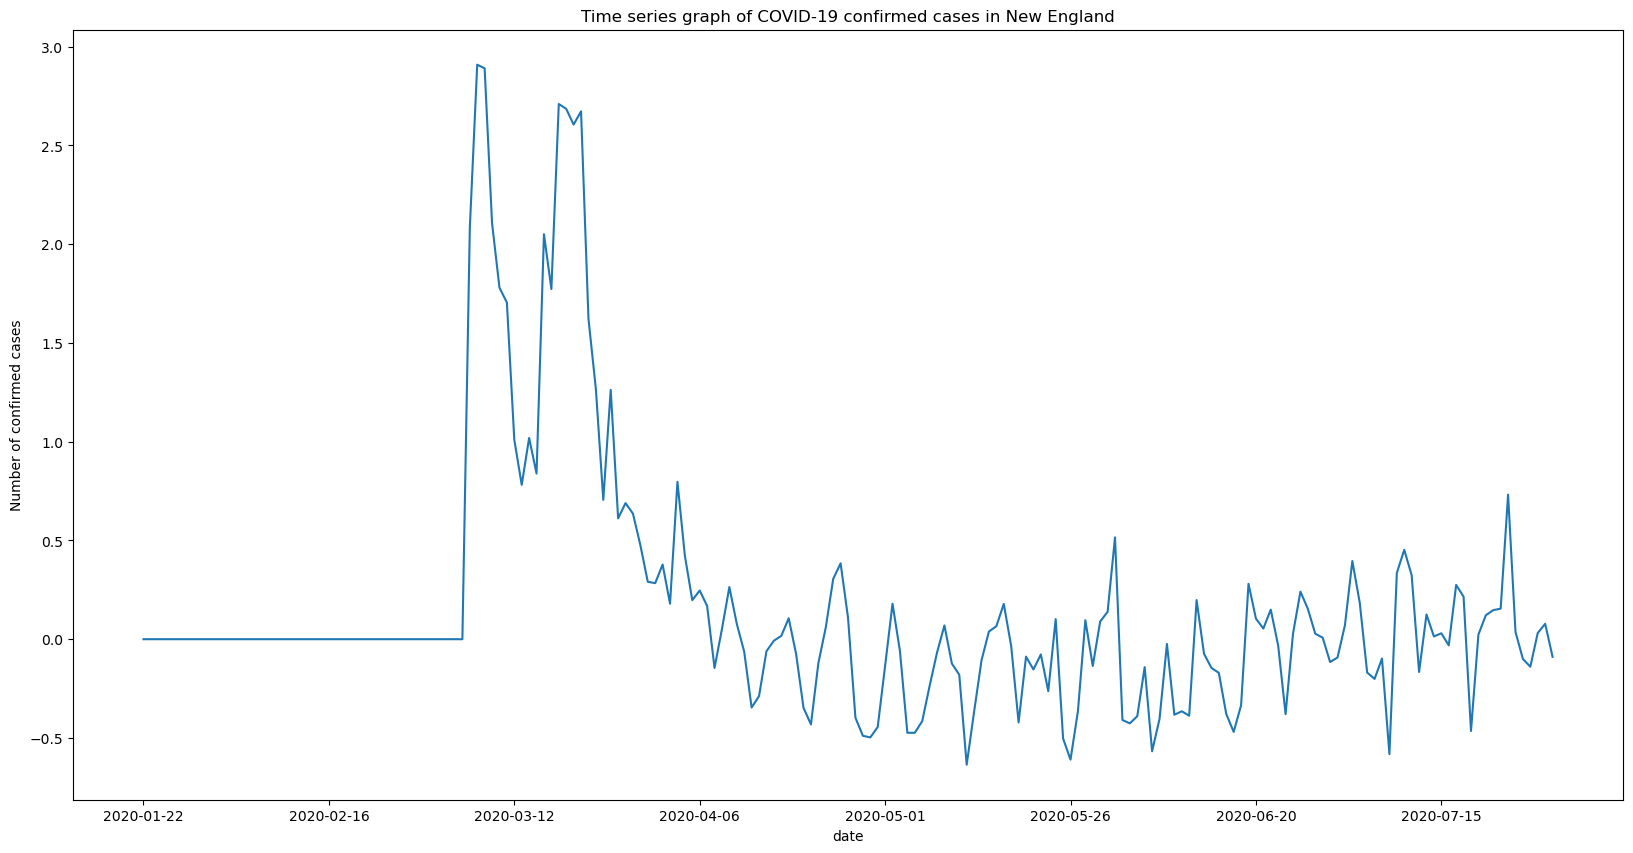

In [79]:
ne_train_transformed.plot(x = "date", y = "covid_19_confirmed_cases", figsize = (20,10),
             title = "Time series graph of COVID-19 confirmed cases in New England",
             ylabel = "Number of confirmed cases",
             legend = False)

In [80]:
adf_test(ne_train_y)

Results of Dickey-Fuller Test:
Test Statistic                  -2.757330
p-value                          0.064632
#Lags Used                      15.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64


In [81]:
kpss_test(ne_train_y)

Results of KPSS Test:
Test Statistic           0.418071
p-value                  0.069366
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [82]:
s_train_y = pd.Series(np.log(s_train["covid_19_confirmed_cases"])).diff(periods = 5).fillna(0)
s_train_y.replace([np.inf, -np.inf], 0, inplace=True)

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [83]:
s_train_transformed = pd.merge(s_train.date, s_train_y, left_index=True, right_index=True)

<Axes: title={'center': 'Time series graph of COVID-19 confirmed cases in the South'}, xlabel='date', ylabel='Number of confirmed cases'>

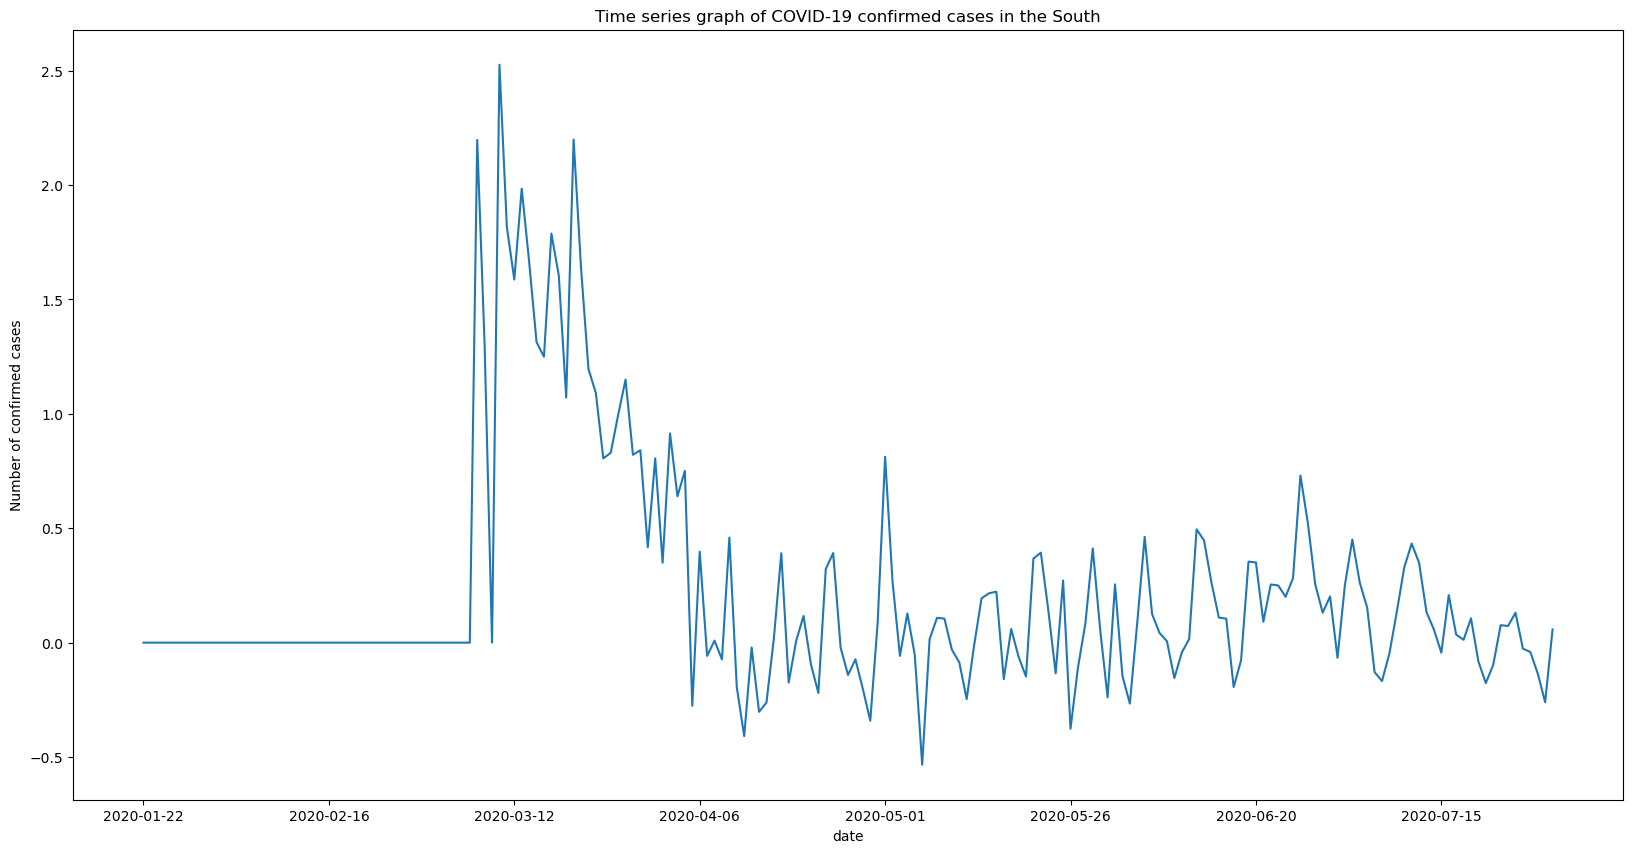

In [84]:
s_train_transformed.plot(x = "date", y = "covid_19_confirmed_cases", figsize = (20,10),
             title = "Time series graph of COVID-19 confirmed cases in the South",
             ylabel = "Number of confirmed cases",
             legend = False)

In [85]:
adf_test(s_train_y)

Results of Dickey-Fuller Test:
Test Statistic                  -2.863843
p-value                          0.049717
#Lags Used                      15.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64


In [86]:
kpss_test(s_train_y)

Results of KPSS Test:
Test Statistic           0.240179
p-value                  0.100000
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/var/folders/47/fwys2xf93ng018yvjrnr0hmm0000gn/T/ipykernel_5831/3002020788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


In [87]:
# Transform Test Data
ne_test_y = pd.Series(np.log(ne_test["covid_19_confirmed_cases"])).diff(periods = 5).fillna(0)
ne_test_y.replace([np.inf, -np.inf], 0, inplace=True)
ne_test_transformed = pd.merge(ne_test.date, ne_test_y, left_index=True, right_index=True)

s_test_y = pd.Series(np.log(s_test["covid_19_confirmed_cases"])).diff(periods = 5).fillna(0)
s_test_y.replace([np.inf, -np.inf], 0, inplace=True)
s_test_transformed = pd.merge(s_test.date, s_test_y, left_index=True, right_index=True)

# Autocorrelation (ACF)
- Correlation of a time series is found with a lagging version of itself
    - Includes direct and indirect dependence
- The shaded region is a confidence interval --> if the height of the bars is outside this region, it means the correlation is statistically significant
- When a clear trend exists in a time series, the autocorrelation tends to be high at small lags like 1 or 2
- When seasonality exists, the autocorrelation goes up periodically at larger lags
- NE: clear trend; no seasonality
    - Tail off is observed --> AR (AutoRegressive Model)
- S: clear trend; no seasonality
    - Tail off is observed --> AR (AutoRegressive Model)

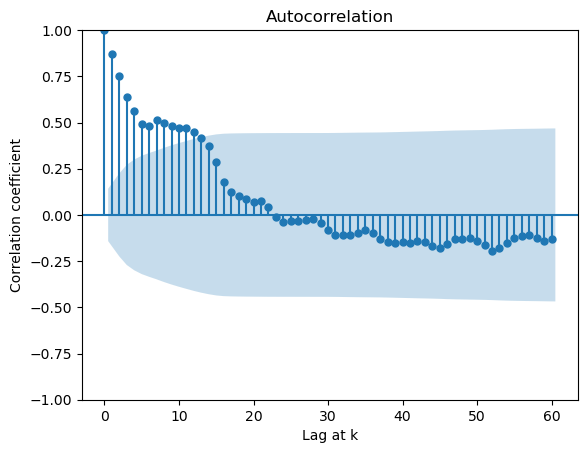

In [88]:
fig = tsaplots.plot_acf(ne_train_transformed["covid_19_confirmed_cases"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

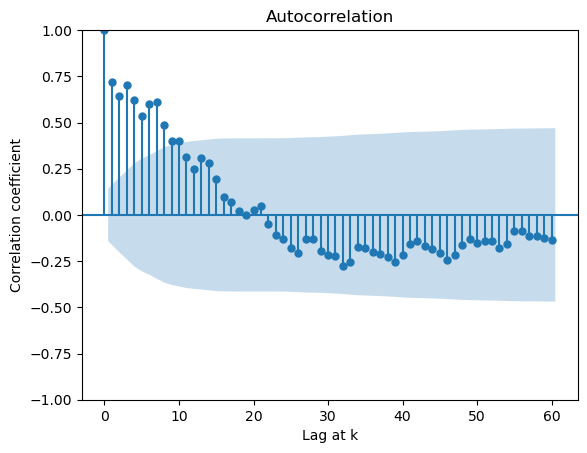

In [89]:
fig = tsaplots.plot_acf(s_train_transformed["covid_19_confirmed_cases"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

# Partial Autocorrelation (PACF)
- Correlation between the data and its lagged values after removing the effect of the intermediate values
    - Includes only direct dependence
- NE: Cut off at lag 2; Does not tail off
- S: Cut off at lag 4; Does not tail off

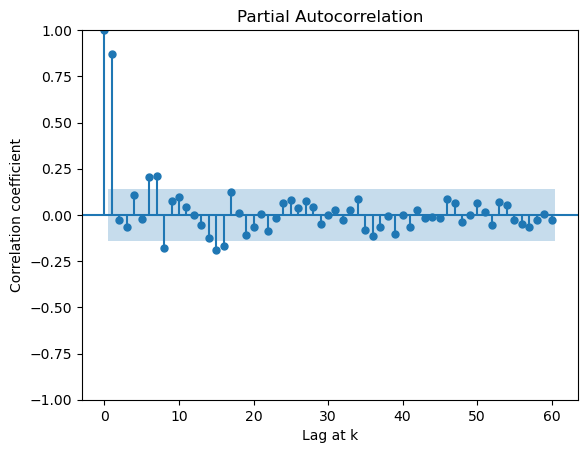

In [90]:
fig = tsaplots.plot_pacf(ne_train_transformed["covid_19_confirmed_cases"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

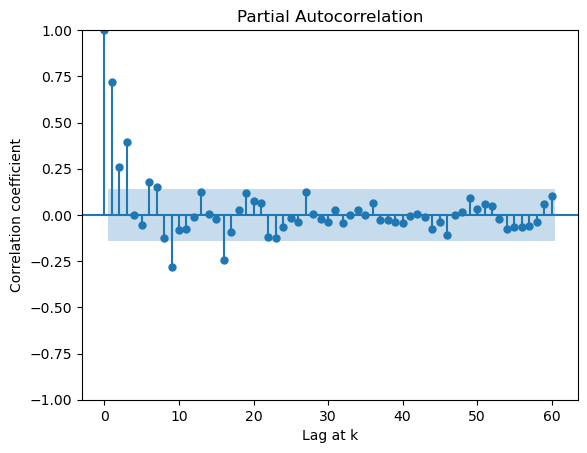

In [91]:
fig = tsaplots.plot_pacf(s_train_transformed["covid_19_confirmed_cases"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

# ARIMA Models
- ARIMA(p,d,q)
    - p: The number of lag observations included in the model
    - d: The number of times that the raw observations are differenced
    - q: The size of the moving average window
- If tail off at ACF --> AR model --> Cut off at PACF will provide order p for AR(p)

## NE Model #1
- (2, 5, 0)
    - ACF graph shows tail off
    - Differencing 5 times makes the data most stationary
    - PACF shows cut off at lag 2
- Residual stats show that there is no bias in the prediction
    - zero mean in the residuals
- Visualization of train data fitted values shows relatively good fits and no over-fitting but possibly underfitting
- MAE is large (1241 confirmed cases)

In [92]:
ne_train_transformed.set_index("date", inplace = True)

In [107]:
ne_test_transformed.set_index("date", inplace = True)

In [100]:
ne_model = ARIMA(ne_train_transformed, order=(2,5,0))
ne_model_fit = ne_model.fit()

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [101]:
print(ne_model_fit.summary())

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                  191
Model:                       ARIMA(2, 5, 0)   Log Likelihood                -312.565
Date:                      Wed, 08 Nov 2023   AIC                            631.131
Time:                              23:51:14   BIC                            640.808
Sample:                          01-22-2020   HQIC                           635.052
                               - 07-30-2020                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3318      0.053    -25.343      0.000      -1.435      -1.229
ar.L2         -0.5843      0.054    -10.830      0.000      -0.690      -0.479
sigm

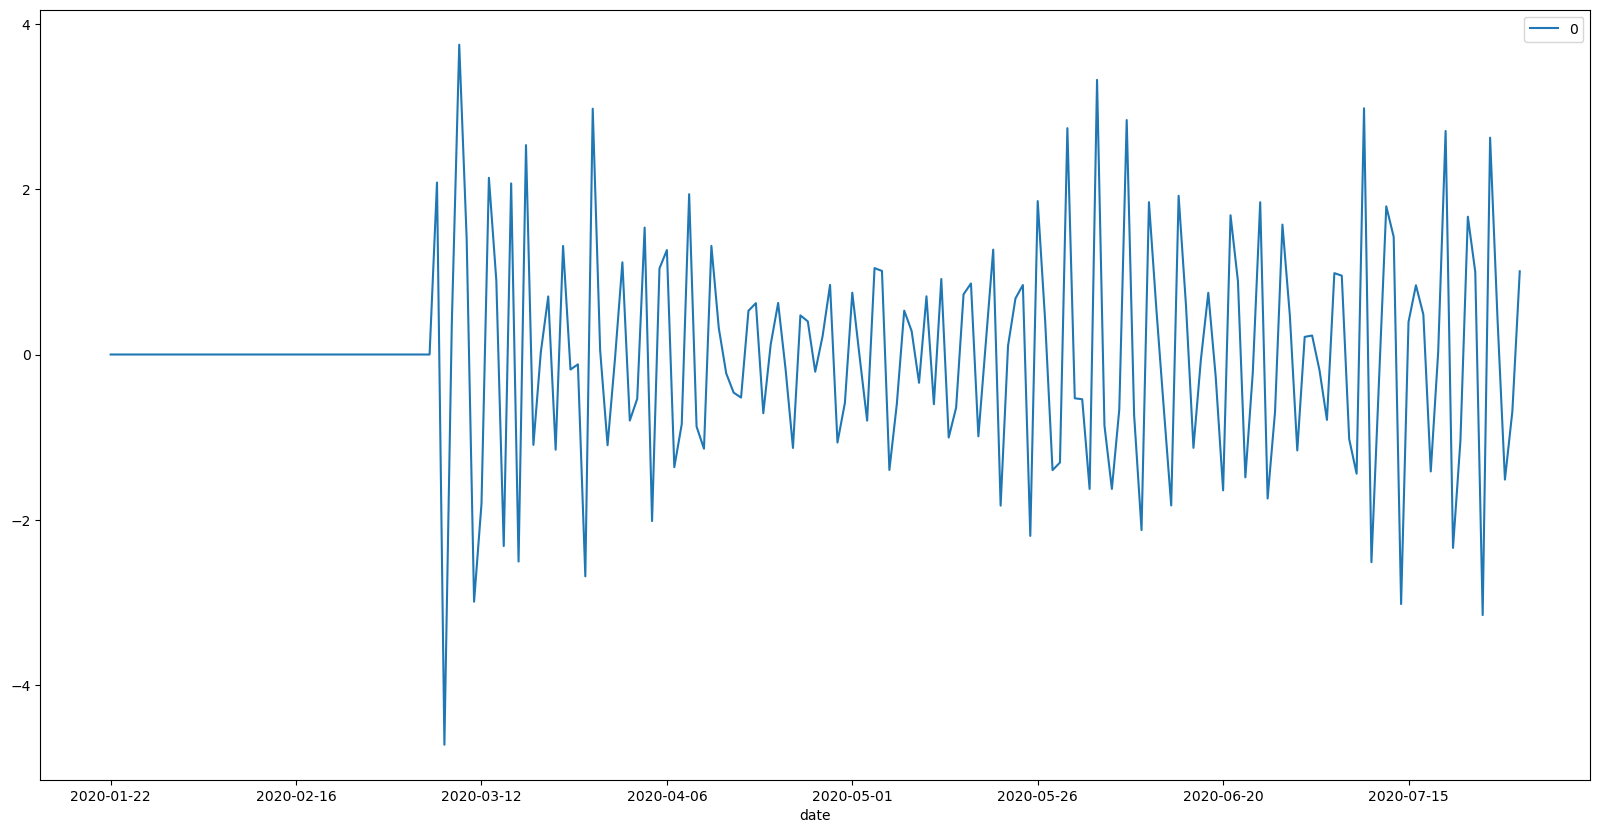

In [102]:
# line plot of residuals
residuals = DataFrame(ne_model_fit.resid)
residuals.plot(figsize = (20,10))
plt.show()

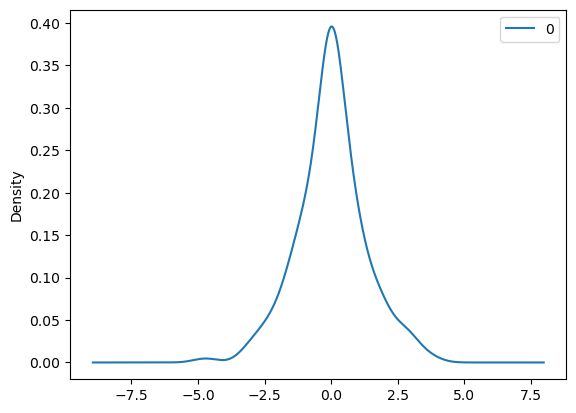

In [103]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [104]:
# summary stats of residuals
print(residuals.describe())

                0
count  191.000000
mean    -0.000080
std      1.278056
min     -4.719170
25%     -0.691316
50%      0.000000
75%      0.690231
max      3.746472


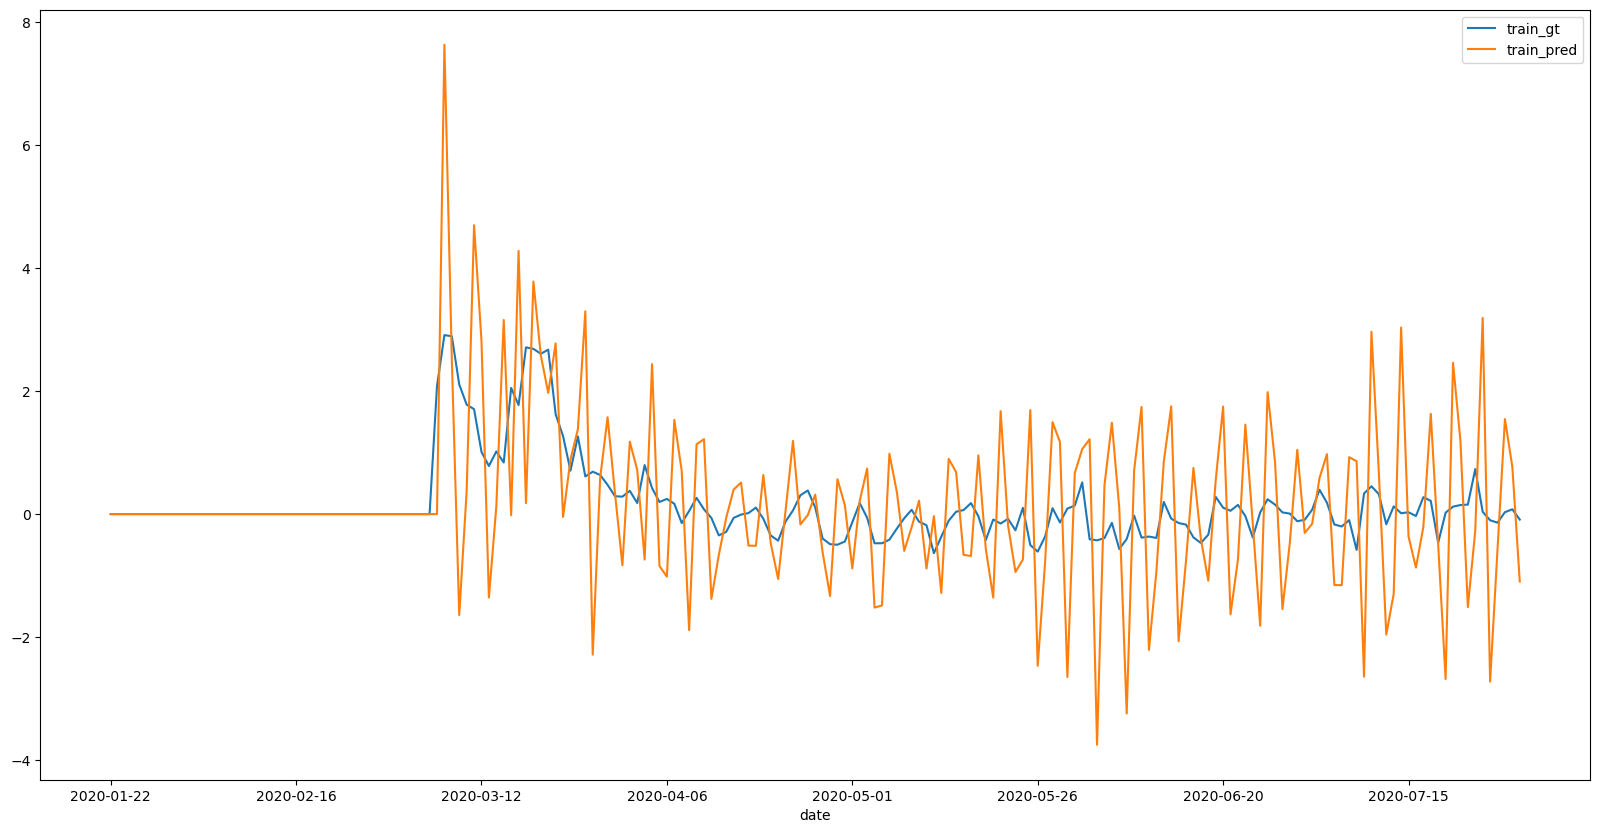

In [140]:
# Visualizing train data fitted values
ne_train_pred = ne_model_fit.fittedvalues
pd.concat([ne_train_transformed, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

### NE Model #1 Forecast

In [136]:
ne_test_transformed.index = pd.to_datetime(ne_test_transformed.index)

In [137]:
ne_test_pred = ne_model_fit.predict(start = len(ne_train_transformed), 
                     end = len(ne_train_transformed) + len(ne_test_transformed) -1)

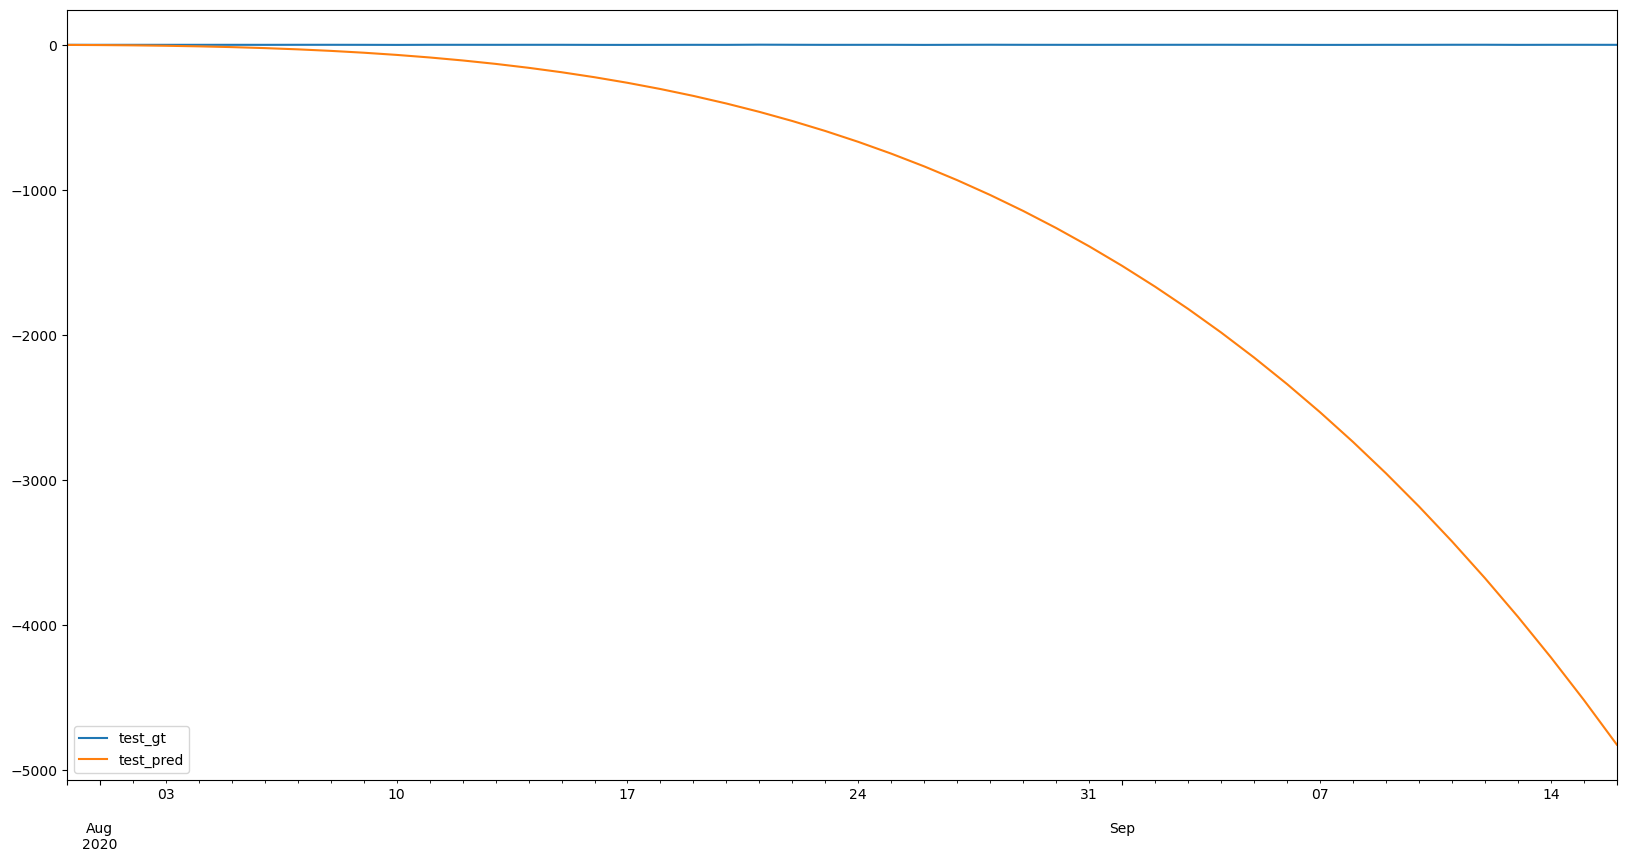

In [141]:
# Visualizing test data fitted values
pd.concat([ne_test_transformed, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [143]:
# MAE
mean_absolute_error(ne_test_transformed, ne_test_pred)

1241.2519770429537

## S Model #1
- (4, 5, 0)
    - ACF graph shows tail off
    - Differencing 5 times makes the data most stationary
    - PACF shows cut off at lag 4
- Residual stats show that there is no bias in the prediction
    - zero mean in the residuals
- Visualization of train data fitted values shows relatively good fits and no over-fitting; not too much under-fitting
- MAE is large (3047 confirmed cases)

In [144]:
s_train_transformed.set_index("date", inplace = True)
s_test_transformed.set_index("date", inplace = True)

In [145]:
s_model = ARIMA(s_train_transformed, order=(4,5,0))
s_model_fit = s_model.fit()

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [146]:
print(s_model_fit.summary())

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                  191
Model:                       ARIMA(4, 5, 0)   Log Likelihood                -260.709
Date:                      Thu, 09 Nov 2023   AIC                            531.418
Time:                              00:14:22   BIC                            547.546
Sample:                          01-22-2020   HQIC                           537.954
                               - 07-30-2020                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1991      0.031    -71.844      0.000      -2.259      -2.139
ar.L2         -2.5969      0.061    -42.730      0.000      -2.716      -2.478
ar.L

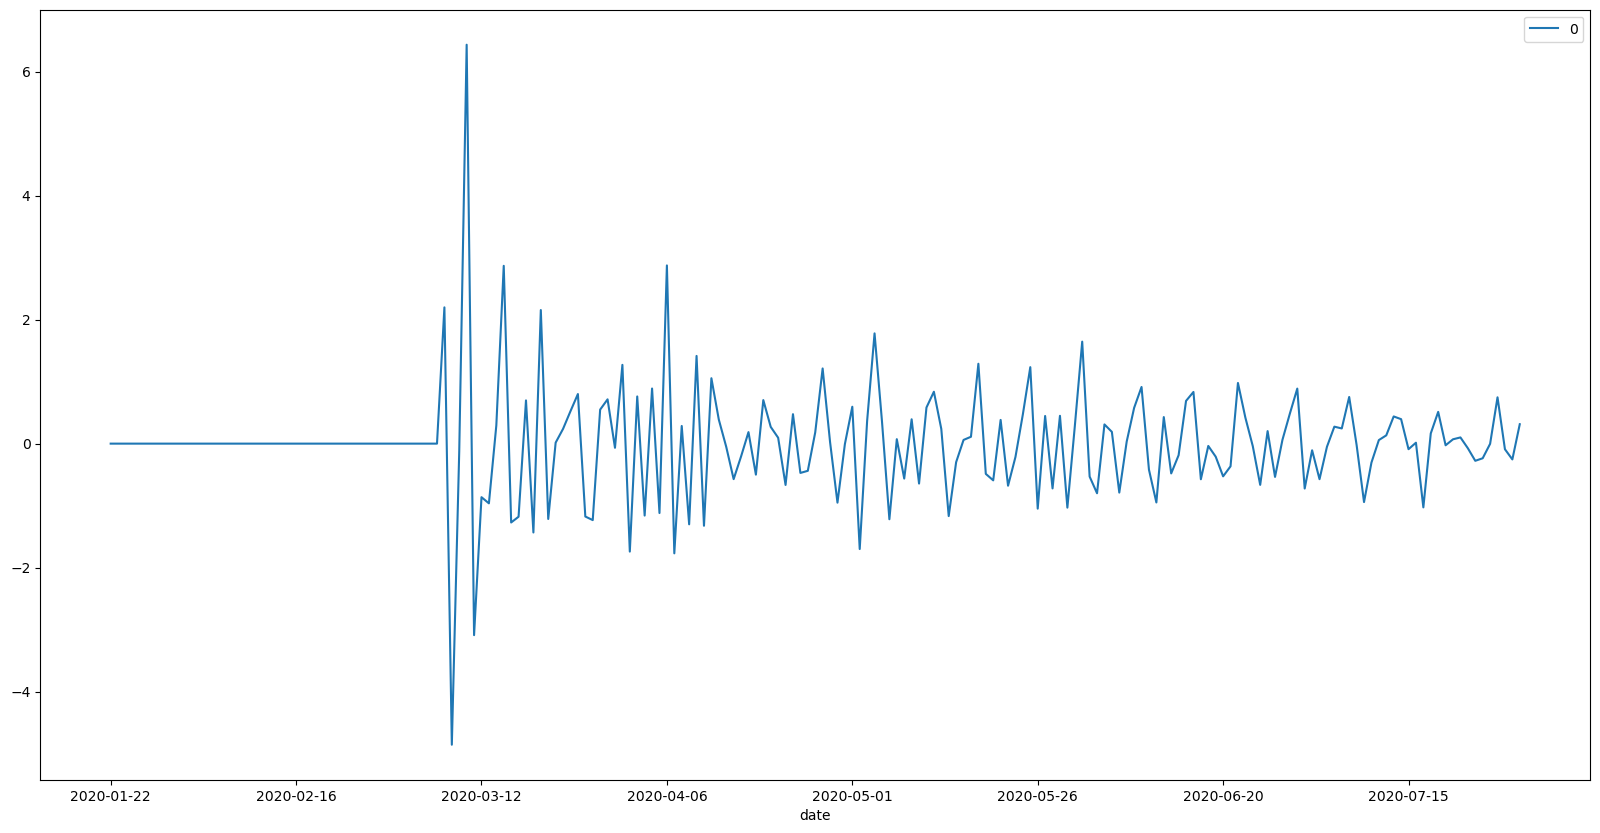

In [147]:
# line plot of residuals
residuals = DataFrame(s_model_fit.resid)
residuals.plot(figsize = (20,10))
plt.show()

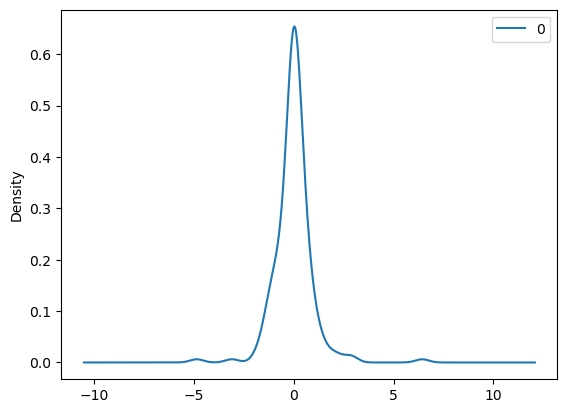

In [148]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [149]:
# summary stats of residuals
print(residuals.describe())

                0
count  191.000000
mean     0.001792
std      0.956144
min     -4.854956
25%     -0.335832
50%      0.000000
75%      0.311427
max      6.432231


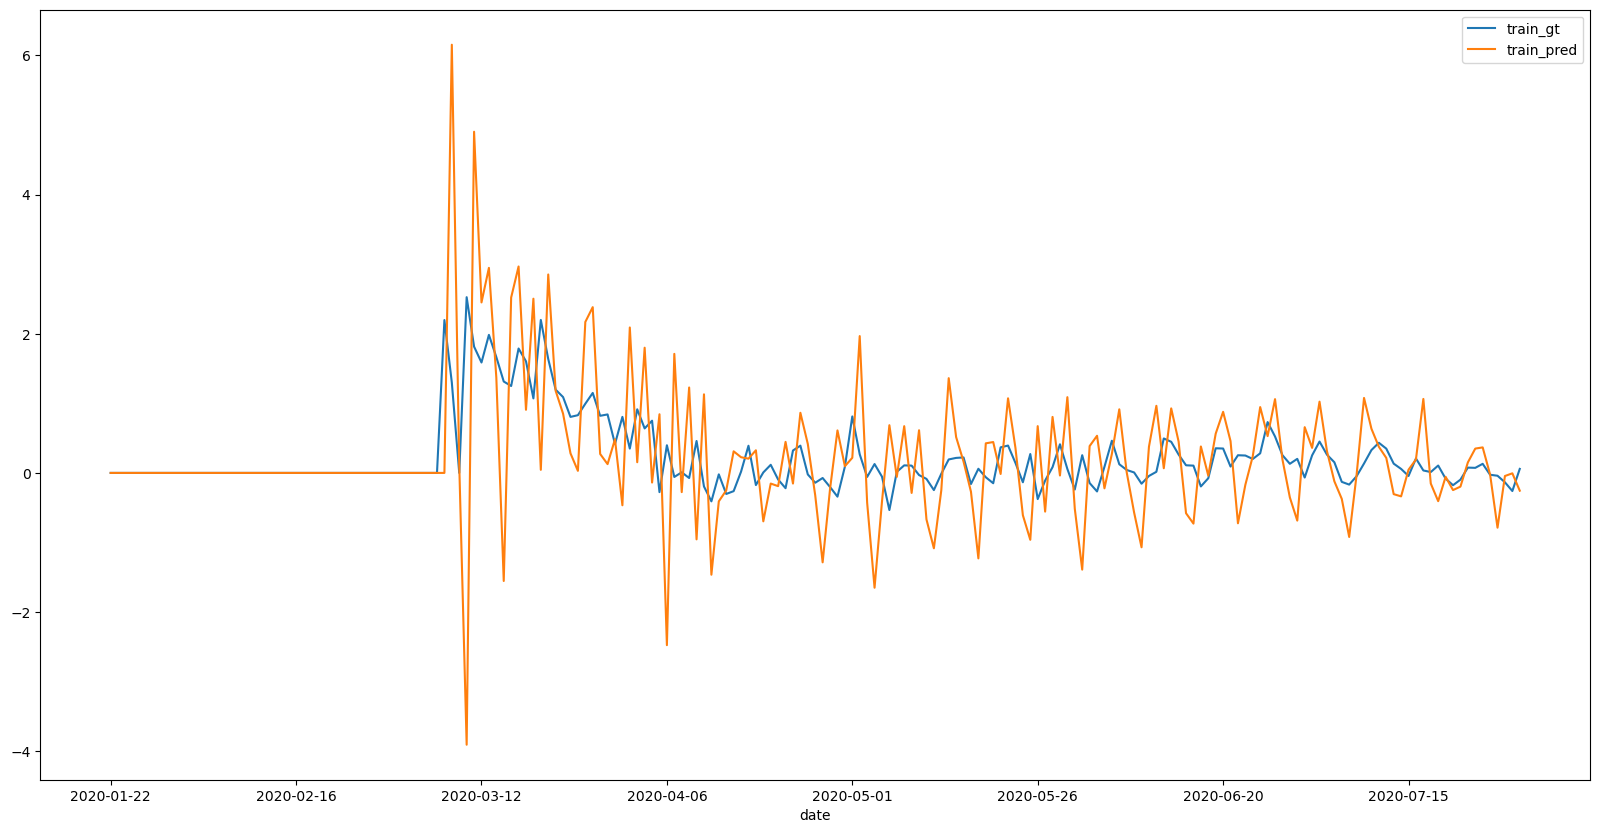

In [150]:
# Visualizing train data fitted values
s_train_pred = s_model_fit.fittedvalues
pd.concat([s_train_transformed, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

### S Model #1 Forecast

In [151]:
s_test_transformed.index = pd.to_datetime(s_test_transformed.index)

In [152]:
s_test_pred = s_model_fit.predict(start = len(s_train_transformed), 
                     end = len(s_train_transformed) + len(s_test_transformed) -1)

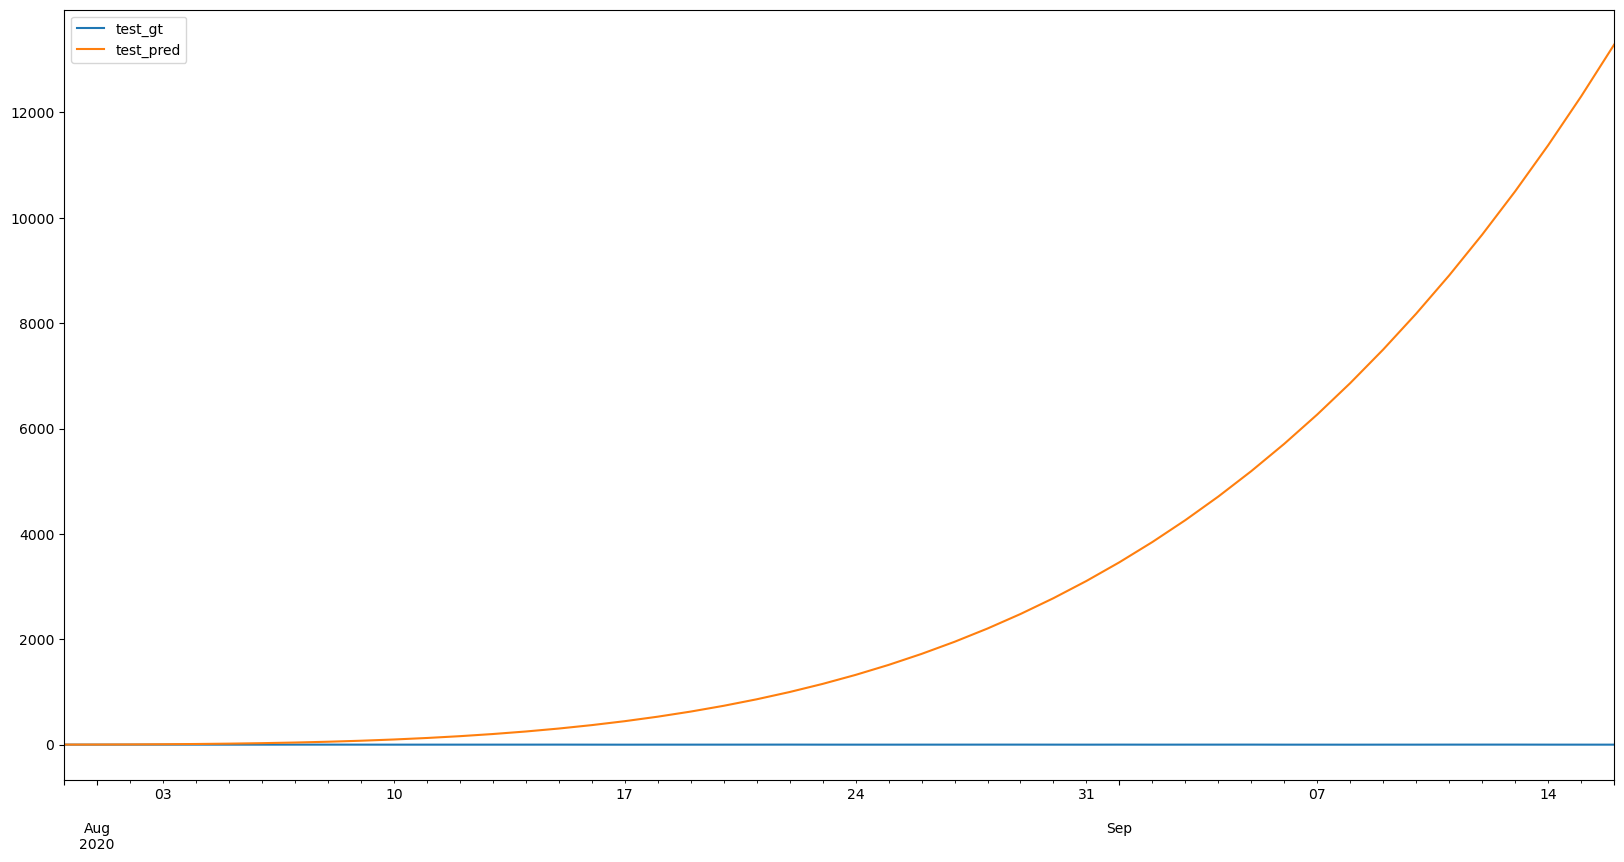

In [153]:
# Visualizing test data fitted values
pd.concat([s_test_transformed, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [155]:
# MAE
mean_absolute_error(s_test_transformed, s_test_pred)

3046.6038055524327